### To Do
- Remove unique columns
- Scaling / Normalization
- outlier analysis => 1) scipy import stats; df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] (for standardizing values into normal distribution), calc zscore and set threshold 2) IQR
- sklearn imputer - replace missing with mean/median/most frequent/constant OR
- replace missing/garbage by using model

# 1. Removing Unique Columns

#### Progress
- Checking which column has as many unique values in it as the total number of rows. Then dropping the column. Eg: Dropping ID columns.

#### Issues
- If a column has an empty value, the number of unique values decreases and is not equal to number of rows. Hence it is not dropped.
- In case a column isnt actually unique identifier eg: sales in different months. There maybe no same sales in two months. Therefore that important column will be dropped.

#### Solution
- Try to find correlation between target variable and predictor variables. If it is close to 0 then drop it.

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def CheckUnique(data):
    col_names = data.columns.to_list()
    print("Original Column Names")
    print(col_names)
    new_col = col_names.copy()
    for i in col_names:
        if data[i].count() == len(data[i].unique()):
            isUniq = True
        else:
            isUniq = False
        if isUniq:
            print("Dropping", i)
            new_col.remove(i)
    return new_col

In [3]:
for i in glob.glob("./Datasets/*"):
    data = pd.read_csv(i)
    print("---------------------------------------------")
    print(i)
    col_names = CheckUnique(data)
    print(col_names)
    print("---------------------------------------------")

---------------------------------------------
./Datasets\cancer.csv
Original Column Names
['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Dropping id
['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetr

# 2. Scaling / Normalization

- In order to identify scale the data, we cannot use the usual scaling methods such as Min Max Scaler or Logarithmic Scaler because they will consider outliers into the data and scale accordingly.
- Therefore we use a Robust Scaling method where we find the interquartile range and scale according to the range so that the data is not affected by outliers.

In [4]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [5]:
data = pd.read_csv("./Datasets/Churn_Modelling.csv")
col_name = CheckUnique(data)
data = data[col_name]
data

Original Column Names
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Dropping RowNumber
Dropping CustomerId


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Hargrave,619,France,Female,42,2.0,0.00,1.0,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1.0,0,1,112542.58,0
2,Onio,502,France,Female,42,8.0,159660.80,3.0,1,0,113931.57,1
3,Boni,699,France,Female,39,1.0,0.00,2.0,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1.0,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Obijiaku,771,France,Male,39,5.0,0.00,2.0,1,0,96270.64,0
9996,Johnstone,516,France,Male,35,10.0,57369.61,1.0,1,1,101699.77,0
9997,Liu,709,France,Female,36,7.0,0.00,1.0,0,1,42085.58,1
9998,Sabbatini,772,Germany,Male,42,3.0,75075.31,2.0,1,0,92888.52,1


In [6]:
def GetNumColumns(data):
    col_names = data.columns.to_list()
    final_col_names = col_names.copy()
    for i in col_names:
        if str(data[i].dtypes) == "object":
            final_col_names.remove(i)
    return final_col_names

In [7]:
def Scaling(data):
    sc = RobustScaler()
    final_col_names = GetNumColumns(data)
    df = data.copy()
    features = data[final_col_names]
    df[final_col_names] = sc.fit_transform(features.values)
    return df

# 3. Outlier Analysis

- The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection.
- The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5

In [8]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()

In [9]:
def remove_outlier(DF, col_name):
    q1 = DF[col_name].quantile(0.25)
    q3 = DF[col_name].quantile(0.75)
    print("25th Percentile of Numerical Attributes")
    print(q1)
    print("----------------------------")
    print("75th Percentile of Numerical Attributes")
    print(q3)
    print("----------------------------")
    IQR = q3-q1 # Interquartile range
    print("Interquartile Range")
    print(IQR)
    d = DF[~((DF[col_name] < (q1 - 1.5 * IQR)) |(DF[col_name] > (q3 + 1.5 * IQR))).any(axis=1)]
    return d

In [10]:
def OutlierAnalysis():
    data = pd.read_csv("./Datasets/Churn_Modelling.csv")  # Reading dataset
    col_name = CheckUnique(data)  # Removing unique columns
    data = data[col_name]  # Columns names which are not unique
    
    print("----------------------------")
    print("Count of null values in continuous attributes")
    print(data.isna().sum())
    cols = GetNumColumns(data)  # get numerical columns
    mice_imputer = IterativeImputer()
    df2 = mice_imputer.fit_transform(data[cols])
    dd = {}
    for i in range(len(cols)):
        dd[cols[i]] = df2[:,i].tolist()
    df4 = pd.DataFrame(dd)
    data[cols] = df4[cols]

    print("----------------------------")
    print("Count of null values after removal in continuous attributes")
    print(data.isna().sum())
    data2 = data[cols]
    print("----------------------------")
    print("Data shape", data.shape)
    print("Copied Data shape", data2.shape)
    yhat = lof.fit_predict(data2.values)  # LOF outlier remover
    mask = yhat != -1
    DF = data[mask]
    print("New Data shape", DF.shape)
    
    print("----------------------------")
    dd = DF.copy()
    dd = remove_outlier(DF, cols)  # Quartile outlier remover
    data = Scaling(dd)  # Scaling Dataset
    dd = remove_outlier(data, cols)  # Removing outliers after scaling
    return dd

# 4. Data Cleaning (replacing values)

In [11]:
from fancyimpute import IterativeImputer

# Main Function Call

In [12]:
def Main():
    final_data = OutlierAnalysis()
    return final_data

In [13]:
final_data = Main()

Original Column Names
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Dropping RowNumber
Dropping CustomerId
----------------------------
Count of null values in continuous attributes
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             4
Balance            0
NumOfProducts      1
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
----------------------------
Count of null values after removal in continuous attributes
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
----------------------------
Data shape (10000, 12)
Copied Data

In [14]:
final_data

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,Hill,-0.337711,Spain,Female,0.5,-1.00,-0.066650,-1.0,-1.0,0.0,0.130360,0.0
3,Boni,0.345216,France,Female,0.3,-1.00,-0.729507,0.0,-1.0,-1.0,-0.060893,0.0
4,Mitchell,1.478424,Spain,Female,0.7,-0.75,0.263189,-1.0,0.0,0.0,-0.211543,0.0
6,Bartlett,1.268293,France,Male,1.4,0.50,-0.729507,0.0,0.0,0.0,-0.916852,0.0
8,He,-1.140713,France,Male,0.8,-0.25,0.394010,0.0,-1.0,0.0,-0.253885,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9993,Rahman,-0.067542,France,Male,-0.8,0.50,0.496904,-1.0,0.0,-1.0,-0.721504,0.0
9994,Wood,1.103189,France,Female,-0.7,-0.75,-0.729507,0.0,-1.0,-1.0,0.694750,0.0
9995,Obijiaku,0.885553,France,Male,0.3,0.00,-0.729507,0.0,0.0,-1.0,-0.035918,0.0
9996,Johnstone,-1.028143,France,Male,-0.1,1.25,-0.275757,-1.0,0.0,0.0,0.019561,0.0


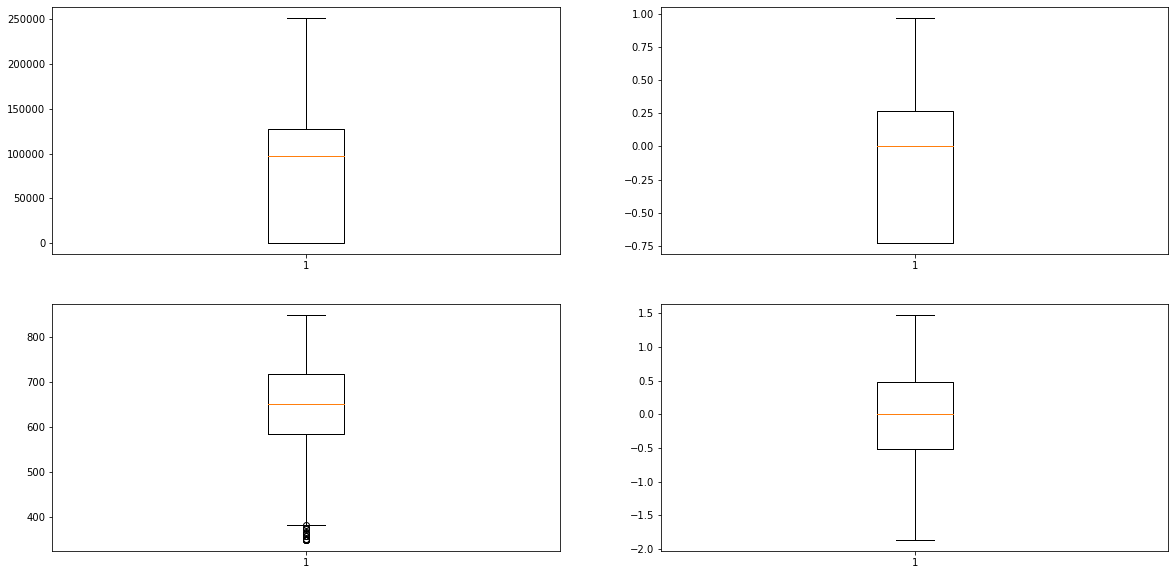

In [15]:
data = pd.read_csv("./Datasets/Churn_Modelling.csv")
plt.rcParams["figure.figsize"] = (20,10)
fig, axis = plt.subplots(2, 2)

axis[0,0].boxplot(data['Balance'])
axis[0,1].boxplot(final_data['Balance'])

axis[1,0].boxplot(data['CreditScore'])
axis[1,1].boxplot(final_data['CreditScore'])

plt.show()

In [16]:
final_data.to_csv('Final_Data.csv', header=True, index=False)